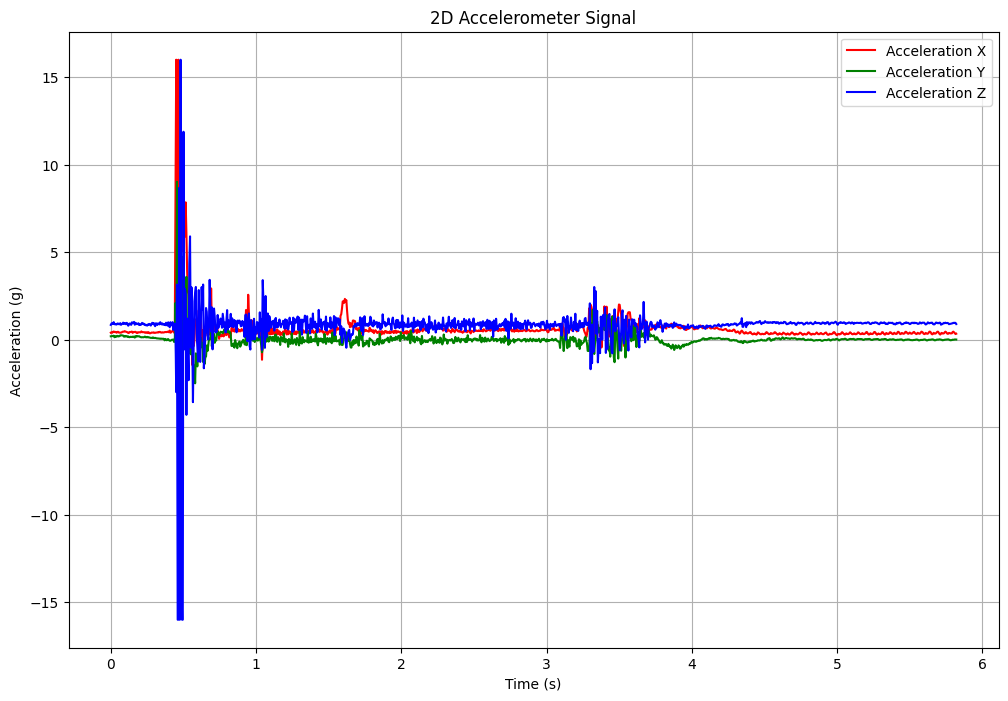

NameError: name 'pd' is not defined

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load JSON data
with open(r'Data\63b6ba0afd4390f3bc15c346\606c2bf94ff42e0002ce4d71.json', 'r') as f:
    data = json.load(f)

# Extract accelerometer data and time
acc_x = np.array(data['Acc_X']['Data'])
acc_y = np.array(data['Acc_Y']['Data'])
acc_z = np.array(data['Acc_Z']['Data'])

total_time = data['TotalTimeRecorded']
num_samples = len(acc_x)
time = np.linspace(0, total_time, num_samples)

# Plotting 2D graphs
plt.figure(figsize=(12, 8))

# Plot Acceleration X
plt.plot(time, acc_x, label='Acceleration X', color='r')

# Plot Acceleration Y
plt.plot(time, acc_y, label='Acceleration Y', color='g')

# Plot Acceleration Z
plt.plot(time, acc_z, label='Acceleration Z', color='b')

# Add labels, title, and legend
plt.title("2D Accelerometer Signal")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# data to df
Acc_X=data['Acc_X']['Data']
Acc_Y=data['Acc_Y']['Data']
Acc_Z=data['Acc_Z']['Data']
gyr_x = data['Sensors'][0]['Data']
gyr_y = (data['Sensors'][1]["Data"])
gyr_z = (data['Sensors'][2]["Data"])
rawData_df = pd.DataFrame(np.array([Acc_X,Acc_Y,Acc_Z,gyr_x,gyr_y,gyr_z]).T, columns=["Acc_X","Acc_Y","Acc_Z",'Gyro_X', 'Gyro_Y', 'Gyro_Z'])


In [ ]:
import json
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


import os
import sys
import copy
sys.path.append(os.path.abspath(os.path.join(".",os.pardir)))
sys.path.append(os.path.join(".", 'Packages'))
sys.path.append(os.path.join(".", 'Architectures'))

from Packages.CrashDetection import CrashDetection, InjuryLevel
from Packages.VirtualSensors import VS
from Packages.MedicalCalculation import MedicalFormulationCalculation, FarSideMitigationCalculation
from Packages.Damages import DamagesPrediction
from Packages.SignalProcessing import SignalProcessing
from Packages.AirBagDeploy import airbag_deploy

%load_ext autoreload
%autoreload 2

In [ ]:
# Crash Detection
# ToDo - SaftyNet
calibInfo = {
    "OperationalMat": np.eye(3),
    "AxesOrientation": "FLU"
}
impactData = {}
offset = [0,0,0]
crashDetectionObj = CrashDetection(".", rawData_df, calibInfo, offset)
crashDict = crashDetectionObj.run()

isCrash, reason = crashDict.get('isCrash')
mechanism = crashDict.get("mechanism")

impactData['Mechanism'] = mechanism
impactData['IsCrash'] = isCrash
impactData['Dv'] = crashDict.get('DV')
impactData['MaxG'] = crashDict.get('maxG')

if isCrash:
    impactData['Confidence'] = crashDict.get('confidence')
    impactData['Theta'] = crashDict.get('theta')

if mechanism == "Rollover":
    listOfInsightData.append(impactData)
    eventService.InsertRelatedData(ins_id, impactData)


In [ ]:
# Virtual Sensors
vs = VS(".", rawData_df, calibInfo, crashDict, offset)
occpVsDict = vs.run()
impactData['VirtualSensors'] = occpVsDict


In [ ]:
# Air Bag deployment
ab_deploy = airbag_deploy.AirBagDeploy(".", rawData_df, calibInfo, crashDict, offset)
ab_deployObj = ab_deploy.run()
impactData['AirBagDeploy'] = ab_deployObj
print(impactData['AirBagDeploy'])

In [ ]:
# Damages
damagesObj = DamagesPrediction(".", rawData_df, calibInfo, crashDict, offset)
damagesResult = damagesObj.run()

impactData['Final'] = damagesResult.get('final')
impactData['Added'] = damagesResult.get('added')
impactData['Removed'] = damagesResult.get('removed')
print((impactData['Final'],impactData['Added'], impactData['Removed']))

In [ ]:
def CalcOccFarSideMitigation(occDict, knownOcc, unknownOcc):
    if occDict is None:
        raise ValueError("occDict is not defined.")
    if knownOcc is None:
        raise ValueError("knownOcc is not defined.")
    if unknownOcc is None:
        raise ValueError("unknownOcc is not defined.")

    try:
        # get known medical criteria
        if knownOcc in occDict.keys():
            medCriteria = occDict[knownOcc].get('MedicalCriteria')
            # calculate FarSideMitigation for unknown occupant
            fsmc = FarSideMitigationCalculation(mechanism, int(unknownOcc), medCriteria)
            farSideDict = fsmc.Run()
            occDict[unknownOcc] = {'MedicalCriteria': farSideDict}
        else:
            raise Exception(f"Occupant {knownOcc} is missing medical criteria.")
    except Exception as ex:
        msg = ex.message if hasattr(ex, 'message') else str(ex.args)
        raise Exception(f"Error while calculating far side mitigation: {msg}")

In [ ]:
# Injuries
injuryLevelObj = InjuryLevel(".", rawData_df, calibInfo, crashDict, offset)
injuryLevelData = injuryLevelObj.run()
occpDict = impactData['Occupants'] = {}
# run medical criteria for each known occupant
for occKey, occVS in occpVsDict.items():
    occLocation = occKey.split('_')[1]  # get the location
    occpDict[occLocation] = {}
    occpDict[occLocation]['VirtualSensors'] = occVS
    mfc = MedicalFormulationCalculation(mechanism, occVS)
    medicalDict = mfc.Run()
    occpDict[occLocation]['MedicalCriteria'] = medicalDict

# run FarSideMitigation only for Side crash
if mechanism == "SideLeft":
    CalcOccFarSideMitigation(occpDict, "1", "2")
    CalcOccFarSideMitigation(occpDict, "4", "3")
elif mechanism == "SideRight":
    CalcOccFarSideMitigation(occpDict, "2", "1")
    CalcOccFarSideMitigation(occpDict, "3", "4")
    
# run Post Process calculations for each occupant
for occVal in occpDict.values():
    MedicalFormulationCalculation.run_post_processing_summary(occVal["MedicalCriteria"])

In [ ]:
impactData.keys()

In [10]:
import os
import json

# Function to save impactData to JSON files
def save_impact_data(impactData):
    # Ensure the outputs directory exists
    output_dir = "outputs"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1. Save the whole impactData dictionary
    with open(os.path.join(output_dir, "impactData_full.json"), "w") as f:
        json.dump(impactData, f, indent=4)

    # 2. Save damaged data (Final, Added, Removed)
    damaged_data = {key: impactData[key] for key in ['Final', 'Added', 'Removed'] if key in impactData}
    with open(os.path.join(output_dir, "damaged_data.json"), "w") as f:
        json.dump(damaged_data, f, indent=4)

    # 3. Save injuries data (Occupants)
    injuries_data = {'Occupants': impactData.get('Occupants', {})}
    with open(os.path.join(output_dir, "injuries_data.json"), "w") as f:
        json.dump(injuries_data, f, indent=4)

    # 4. Save VirtualSensors data
    virtual_sensors_data = {'VirtualSensors': impactData.get('VirtualSensors', {})}
    with open(os.path.join(output_dir, "virtual_sensors_data.json"), "w") as f:
        json.dump(virtual_sensors_data, f, indent=4)

    # 5. Save Crash data (all other keys)
    crash_data = {key: value for key, value in impactData.items() if key not in ['Final', 'Added', 'Removed', 'Occupants', 'VirtualSensors']}
    with open(os.path.join(output_dir, "crash_data.json"), "w") as f:
        json.dump(crash_data, f, indent=4)

# Call the function to save data
save_impact_data(impactData)
